In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

In [36]:
from sklearn.datasets import fetch_california_housing

# Load dataset
cal_housing = fetch_california_housing(as_frame=True)
df = cal_housing.frame

# Display the first few rows 
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [37]:
# Store the column name of the target variable
target_column = 'MedHouseVal'

# Store the names of the feature variables (excluding the target variable)
feature_columns = df.drop(columns=target_column).columns.tolist()

# Print the results
print("Target Column:", target_column)
print("Feature Columns:", feature_columns)

Target Column: MedHouseVal
Feature Columns: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [38]:
# Check for missing values
df.isnull().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

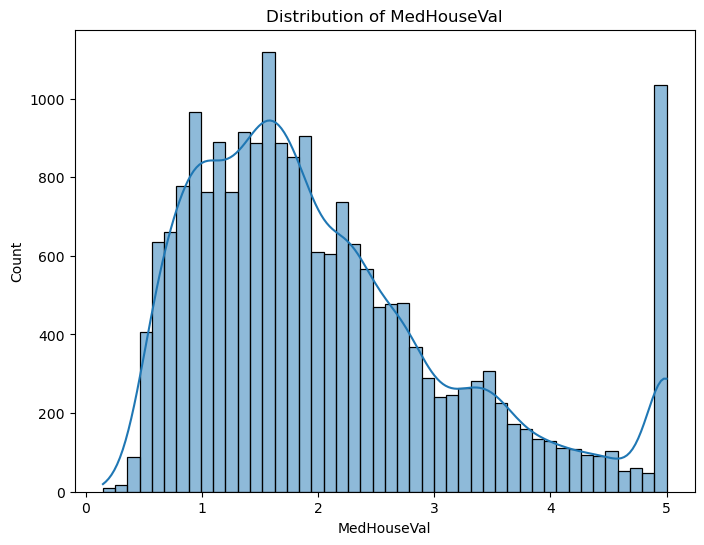

In [39]:
# Plot the distribution for the target variable (MedHouseVal)
plt.figure(figsize=(8, 6))
sns.histplot(df[target_column], kde=True)
plt.title(f"Distribution of {target_column}")
plt.show()

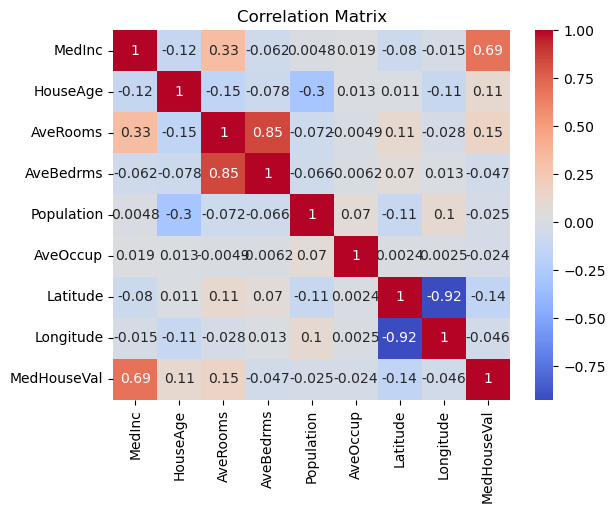

In [40]:
# Correlation matrix heatmap
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

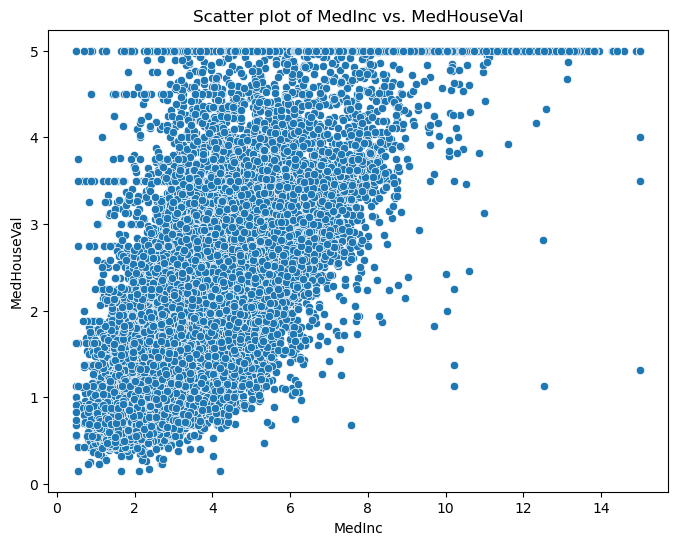

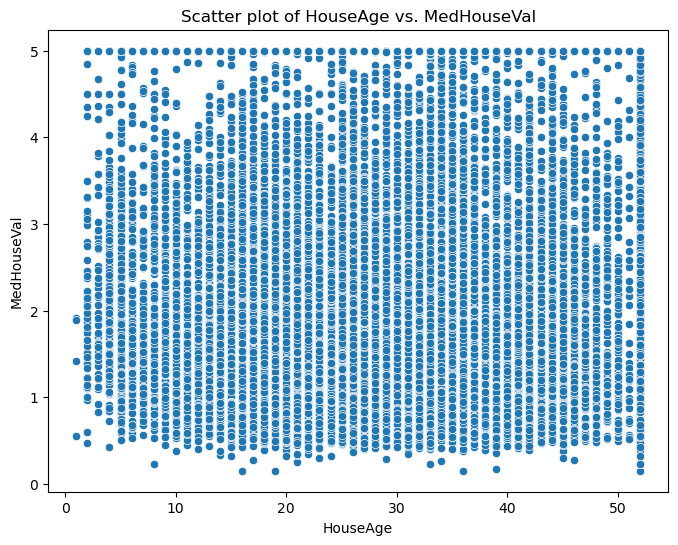

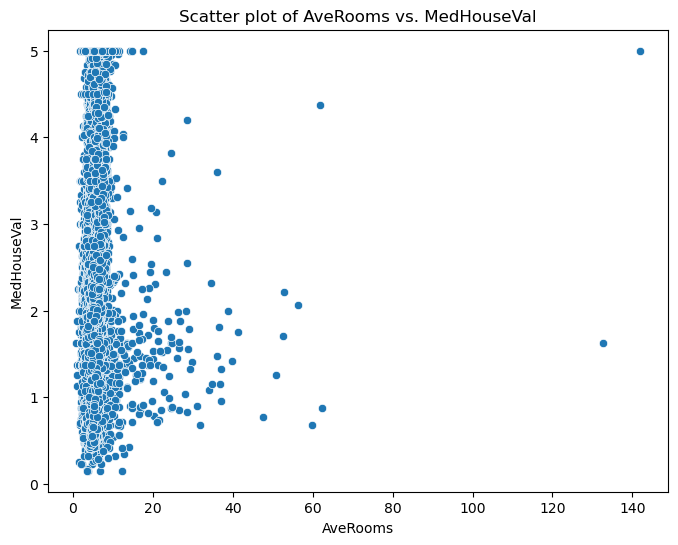

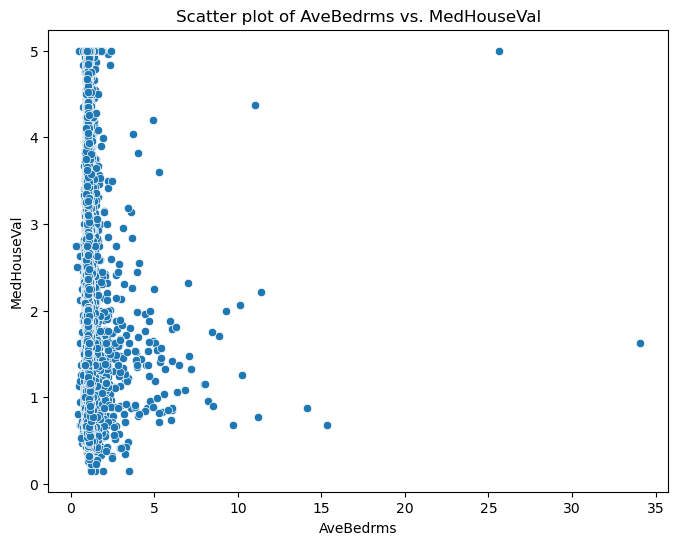

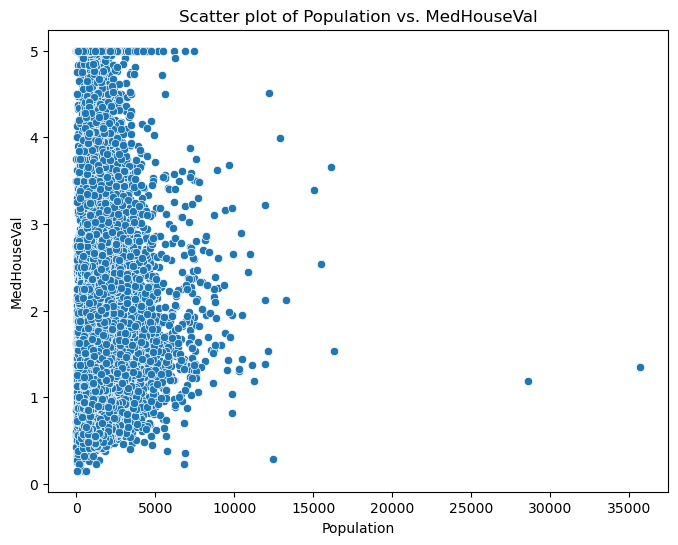

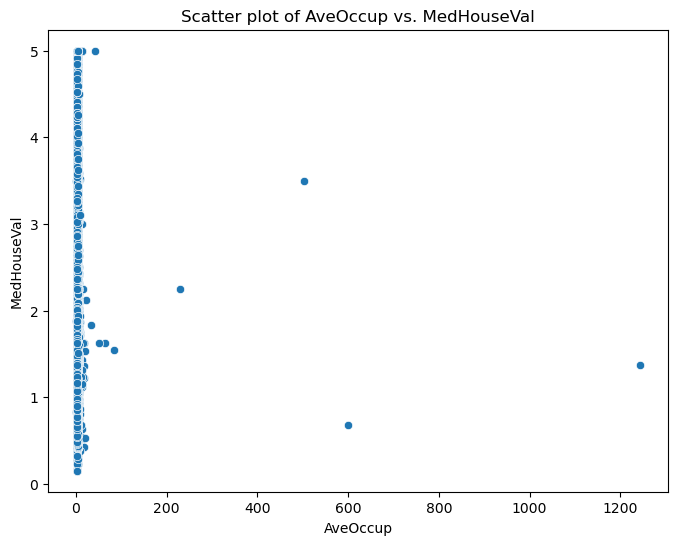

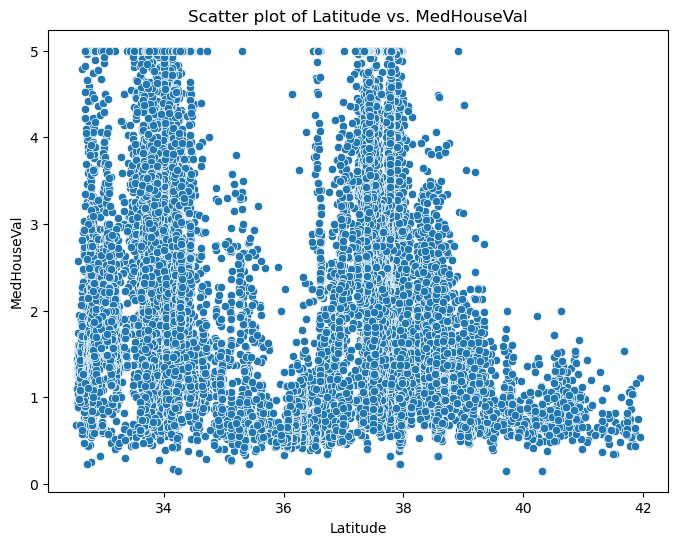

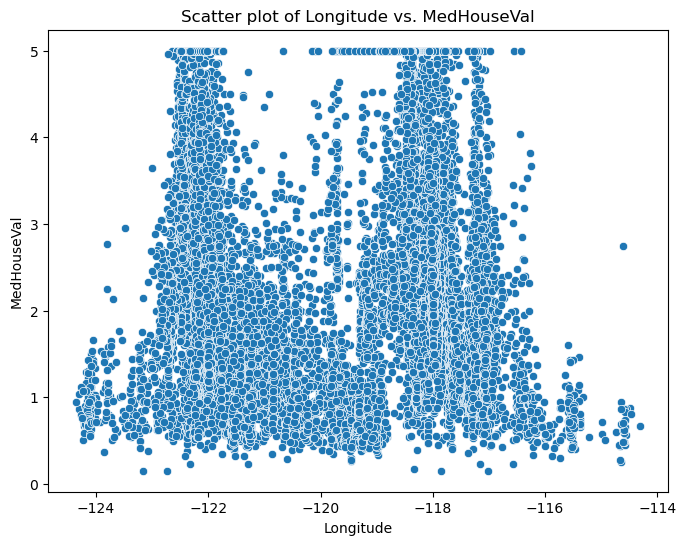

In [41]:
for column in feature_columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=column, y=df[target_column])
    plt.title(f"Scatter plot of {column} vs. {target_column}")
    plt.xlabel(column)
    plt.ylabel(target_column)
    plt.show()

In [42]:
# Define independent variables (X) and dependent variable (y)
# Drop the 'AveBedrms' feature
X = df.drop(columns=['AveBedrms', 'MedHouseVal'])  # Drop target variable as well
y = df['MedHouseVal']


# Add constant to the model (for intercept)
X = sm.add_constant(X)


In [68]:
# Fit the GLM
glm_model = sm.GLM(y, X, family=sm.families.Gaussian())
glm_results = glm_model.fit()

# Print the summary of the model
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:            MedHouseVal   No. Observations:                20640
Model:                            GLM   Df Residuals:                    20632
Model Family:                Gaussian   Df Model:                            7
Link Function:               Identity   Scale:                         0.53789
Method:                          IRLS   Log-Likelihood:                -22883.
Date:                Mon, 09 Dec 2024   Deviance:                       11098.
Time:                        23:16:33   Pearson chi2:                 1.11e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7714
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -39.0492      0.661    -59.103      0.0

In [69]:
# Predictions on the same dataset
y_pred = glm_results.predict(X)

# Calculate residuals (actual - predicted)
residuals = y - y_pred

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean(residuals**2))
print(f"RMSE: {rmse}")

# R-squared value (goodness of fit)
from sklearn.metrics import r2_score
r2 = r2_score(y, y_pred)
print(f"R-squared: {r2}")


RMSE: 0.7332670489914099
R-squared: 0.5961995839710021


In [73]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define independent variables (X) and dependent variable (y)
X = df.drop(columns=['AveBedrms', 'MedHouseVal'])  # Drop target variable 'MedHouseVal' and 'AveBedrms'
y = df['MedHouseVal']

# Standardize the features (important if features have different scales)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Add constant term to the features (intercept term)
X_with_const = sm.add_constant(X_scaled_df)

# Fit the initial GLM model
glm_model = sm.GLM(y, X_with_const, family=sm.families.Gaussian())
glm_results = glm_model.fit()

# Function for iterative model reduction based on p-values
def reduce_model_by_pvalues(glm_results, X_with_const, y, threshold=0.05):
    while glm_results.pvalues.max() > threshold:
        feature_to_remove = glm_results.pvalues.idxmax()  # Feature with the max p-value
        print(f"Dropping feature: {feature_to_remove} with p-value {glm_results.pvalues[feature_to_remove]:.4f}")
        X_with_const = X_with_const.drop(columns=[feature_to_remove])
        glm_model = sm.GLM(y, X_with_const, family=sm.families.Gaussian())
        glm_results = glm_model.fit()

    return glm_results, X_with_const

# Apply p-value reduction to the already fitted model
glm_results_pvalue, X_reduced = reduce_model_by_pvalues(glm_results, X_with_const, y)

# Print the summary of the reduced model
print(glm_results_pvalue.summary())

# Make predictions using the reduced model
y_pred = glm_results_pvalue.predict(X_reduced)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"RMSE for the reduced model: {rmse:.4f}")
# Calculate R²
r2 = r2_score(y, y_pred)
print(f"R-squared for the reduced model: {r2:.4f}")


Dropping feature: Population with p-value 0.5030
                 Generalized Linear Model Regression Results                  
Dep. Variable:            MedHouseVal   No. Observations:                20640
Model:                            GLM   Df Residuals:                    20633
Model Family:                Gaussian   Df Model:                            6
Link Function:               Identity   Scale:                         0.53787
Method:                          IRLS   Log-Likelihood:                -22884.
Date:                Mon, 09 Dec 2024   Deviance:                       11098.
Time:                        23:32:11   Pearson chi2:                 1.11e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7714
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
con

In [74]:
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error

# Step 1: Assume the dataset X is already pre-processed and 'AveBedrms' is dropped
# Add the constant (intercept) term to the dataset
X_with_const = sm.add_constant(X)

# Step 2: Fit the full GLM model with all features (except AveBedrms)
y = df['MedHouseVal']  # Assuming 'MedHouseVal' is the target variable
glm_full_model = sm.GLM(y, X_with_const, family=sm.families.Gaussian()).fit()

# Step 3: Start the AIC-based stepwise feature selection process
current_model = glm_full_model
current_AIC = current_model.aic
best_model = current_model
best_AIC = current_AIC

# Iteratively remove the feature with the highest AIC (and highest p-value)
while True:
    # Check which feature has the highest p-value (exclude constant term)
    max_p_value_feature = current_model.pvalues[1:].idxmax()
    if max_p_value_feature == 'const':
        break  # Stop if only the constant term remains
    
    # Remove the feature with the highest p-value
    X_reduced = X_with_const.drop(columns=[max_p_value_feature])
    
    # Fit a new model without the feature
    glm_reduced_model = sm.GLM(y, X_reduced, family=sm.families.Gaussian()).fit()
    
    # Compare the AIC of the reduced model
    if glm_reduced_model.aic < best_AIC:
        best_model = glm_reduced_model
        best_AIC = glm_reduced_model.aic
        current_model = glm_reduced_model
        X_with_const = X_reduced  # Update X_with_const for the next iteration
    else:
        break  # Exit if no improvement in AIC

# Step 5: Print the summary of the reduced model
print("\nSummary of the AIC Reduced Model:")
print(best_model.summary())
# Step 4: After reduction, get predictions and evaluate the model
y_pred_aic = best_model.predict(X_with_const)

# Calculate RMSE (Root Mean Squared Error)
rmse_aic = np.sqrt(mean_squared_error(y, y_pred_aic))
print(f"RMSE for AIC reduced model: {rmse_aic}")

# Calculate R²
r2 = r2_score(y, y_pred_aic)
print(f"R-squared for the reduced model: {r2:.4f}")
# Calculate McFadden's Pseudo R-squared
llf_full = best_model.llf  # Log-likelihood of the full model
llf_null = best_model.llnull  # Log-likelihood of the null model

# McFadden's R-squared
pseudo_r2_aic = 1 - (llf_full / llf_null)
print(f"McFadden's Pseudo R-squared for the AIC reduced model: {pseudo_r2_aic}")



Summary of the AIC Reduced Model:
                 Generalized Linear Model Regression Results                  
Dep. Variable:            MedHouseVal   No. Observations:                20640
Model:                            GLM   Df Residuals:                    20633
Model Family:                Gaussian   Df Model:                            6
Link Function:               Identity   Scale:                         0.53787
Method:                          IRLS   Log-Likelihood:                -22884.
Date:                Mon, 09 Dec 2024   Deviance:                       11098.
Time:                        23:34:04   Pearson chi2:                 1.11e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7714
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -39.

In [57]:
# AIC for the AIC reduced model
aic_aic_model = best_model.aic  # Best model from the AIC reduction
print(f"AIC for AIC reduced model: {aic_aic_model}")

# AIC for the p-value reduced model
# Replace 'best_model_pvalue' with the actual model variable you used for p-value reduction
aic_pvalue_model = glm_results_pvalue.aic  # Best model from the p-value reduction
print(f"AIC for P-value reduced model: {aic_pvalue_model}")


AIC for AIC reduced model: 45781.304501379884
AIC for P-value reduced model: 45781.304501379884


In [59]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score
import numpy as np

# Extract the reduced feature set from the AIC-reduced model (`best_model`)
reduced_features = best_model.model.exog_names  # Names of features used in the AIC-reduced model
X_reduced = X_with_const[reduced_features]      # Filter the dataset to match reduced features

# Function to perform train-test split, model fitting, and evaluation
def evaluate_split(train_size, X, y):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-train_size, random_state=42)
    
    # Fit the reduced model on the training data
    X_train_const = sm.add_constant(X_train, has_constant='add')
    X_test_const = sm.add_constant(X_test, has_constant='add')
    reduced_model = sm.GLM(y_train, X_train_const, family=sm.families.Gaussian()).fit()
    
    # Make predictions on the test data
    y_pred = reduced_model.predict(X_test_const)
    
    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    auc = roc_auc_score(np.where(y_test > y_test.median(), 1, 0), y_pred)  # Binary AUC based on median split
    
    return rmse, r2, auc

# Define training sizes for splits
splits = [0.1, 0.3, 0.5]

# Store results
results = {}

# Evaluate the reduced model for each split
for split in splits:
    rmse, r2, auc = evaluate_split(split, X_reduced, y)  # Use X_reduced explicitly derived from best_model
    results[f'{int(split * 100)}:{int((1 - split) * 100)}'] = {'RMSE': rmse, 'R-squared': r2, 'AUC': auc}

# Print results
for split, metrics in results.items():
    print(f"Split {split} -> RMSE: {metrics['RMSE']:.4f}, R-squared: {metrics['R-squared']:.4f}, AUC: {metrics['AUC']:.4f}")


Split 10:90 -> RMSE: 0.7340, R-squared: 0.5946, AUC: 0.8967
Split 30:70 -> RMSE: 0.7338, R-squared: 0.5948, AUC: 0.8950
Split 50:50 -> RMSE: 0.7332, R-squared: 0.5944, AUC: 0.8960
